# Building an AI Movie Night Recommendation Tool


In this project, I developed an AI-powered Movie Recommendation Tool using two datasets:

- **Movies Metadata**: Contains information about ~9,000 movies including titles, descriptions, average ratings, and vote counts.
- **User Ratings**: Includes individual ratings from users, indicating how much they liked each movie.

The project involved building a complete recommendation system through several key stages:

- Performing exploratory data analysis to understand the structure and distribution of the data.
- Creating a baseline recommender using movie popularity (vote count and average rating).
- Implementing personalized recommendations using collaborative filtering based on user rating behavior.
- Leveraging Large Language Models (LLMs) to calculate semantic similarity between movie descriptions.
- Recommending movies based on their similarity to a given set of movie titles by comparing their embeddings.
- Integrating all components into a unified recommendation tool that supports multiple recommendation strategies.

This project showcases my ability to combine data analysis, machine learning, and natural language processing to build a functional and flexible AI system that provides meaningful user recommendations.

## Task 1: Import the ratings and movie metadata and explore it. 

The data is contained in two CSV files named `movies_metadata.csv` and `ratings.csv`

`movies_metadata` contains the following columns: 

- `movie_id`: Unique identifier of each movie. 
- `title`: Title of the movie. 
- `overview`: Short description of the movie. 
- `vote_average`: Average score the movie got.
- `vote_count`: Total number of votes the movie got. 

`ratings` contains the following columns: 

- `user_id`: Unique identifier of the person who rated the movie. 
- `movie_id`: Unique identifier of the movie. 
- `rating`: Value between 0 and 10 indicating how much the person liked the movie. 

### Prompt

Read the movies_metadata file and count how many unique movies there are, visualise the vote_average column and visualise the vote_count column. Next read the ratings file, and count how many unique users have rated how many unique movies. Visualise the distribution of the rating column.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read the movies_metadata file
movies_metadata = pd.read_csv('movies_metadata.csv')

# Read the ratings file
ratings = pd.read_csv('ratings.csv')

In [3]:
# Count how many unique movies there are
unique_movies = movies_metadata['movie_id'].nunique()
print(f"Number of unique movies: {unique_movies}")

# Count how many unique users have rated how many unique movies
unique_users = ratings['user_id'].nunique()
unique_rated_movies = ratings['movie_id'].nunique()
print(f"Number of unique users: {unique_users}")
print(f"Number of unique rated movies: {unique_rated_movies}")

Number of unique movies: 9010
Number of unique users: 671
Number of unique rated movies: 9010


### Distribution of Vote Average

This histogram shows how movies are rated on average by users. Most movies fall within the 5 to 7 rating range, indicating that the majority of titles receive moderate ratings. A small number of movies have exceptionally high average ratings, making them strong candidates for a popularity-based recommendation system.


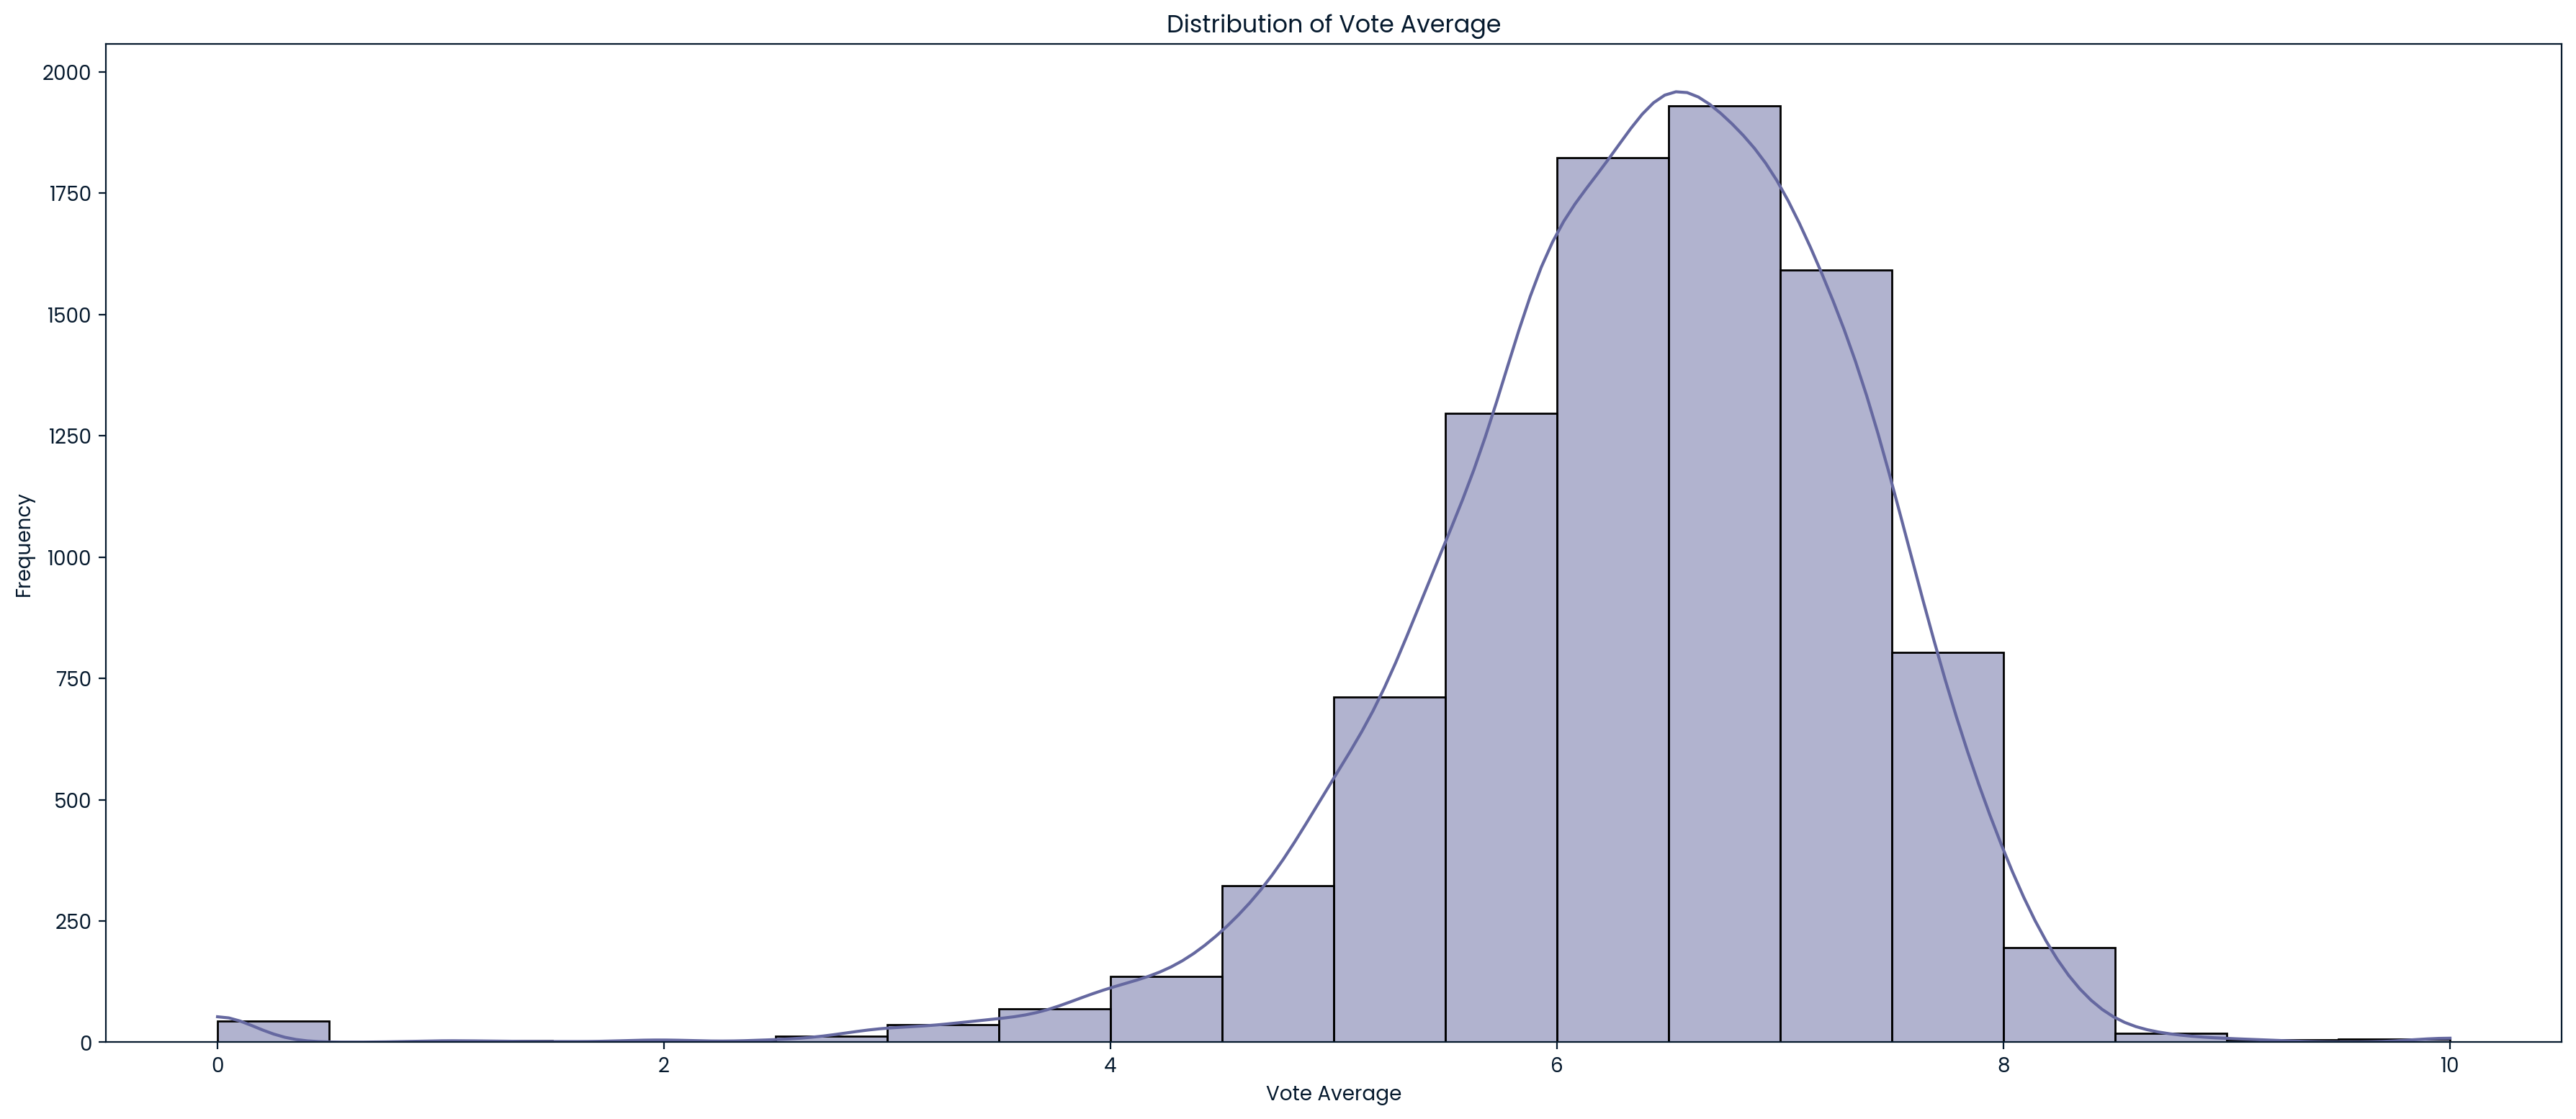

In [4]:


# Visualise the vote_average column
plt.figure(figsize=(22, 9))
sns.histplot(movies_metadata['vote_average'], bins=20, kde=True)
plt.title('Distribution of Vote Average')
plt.xlabel('Vote Average')
plt.ylabel('Frequency')
plt.show()


### Distribution of Vote Count

This plot displays how many votes each movie has received. The distribution is highly skewed: while most movies have relatively few votes, a small number have extremely high counts. These are typically blockbuster or widely known films. Vote count is important to consider because movies with high average ratings but very few votes may not be reliable.


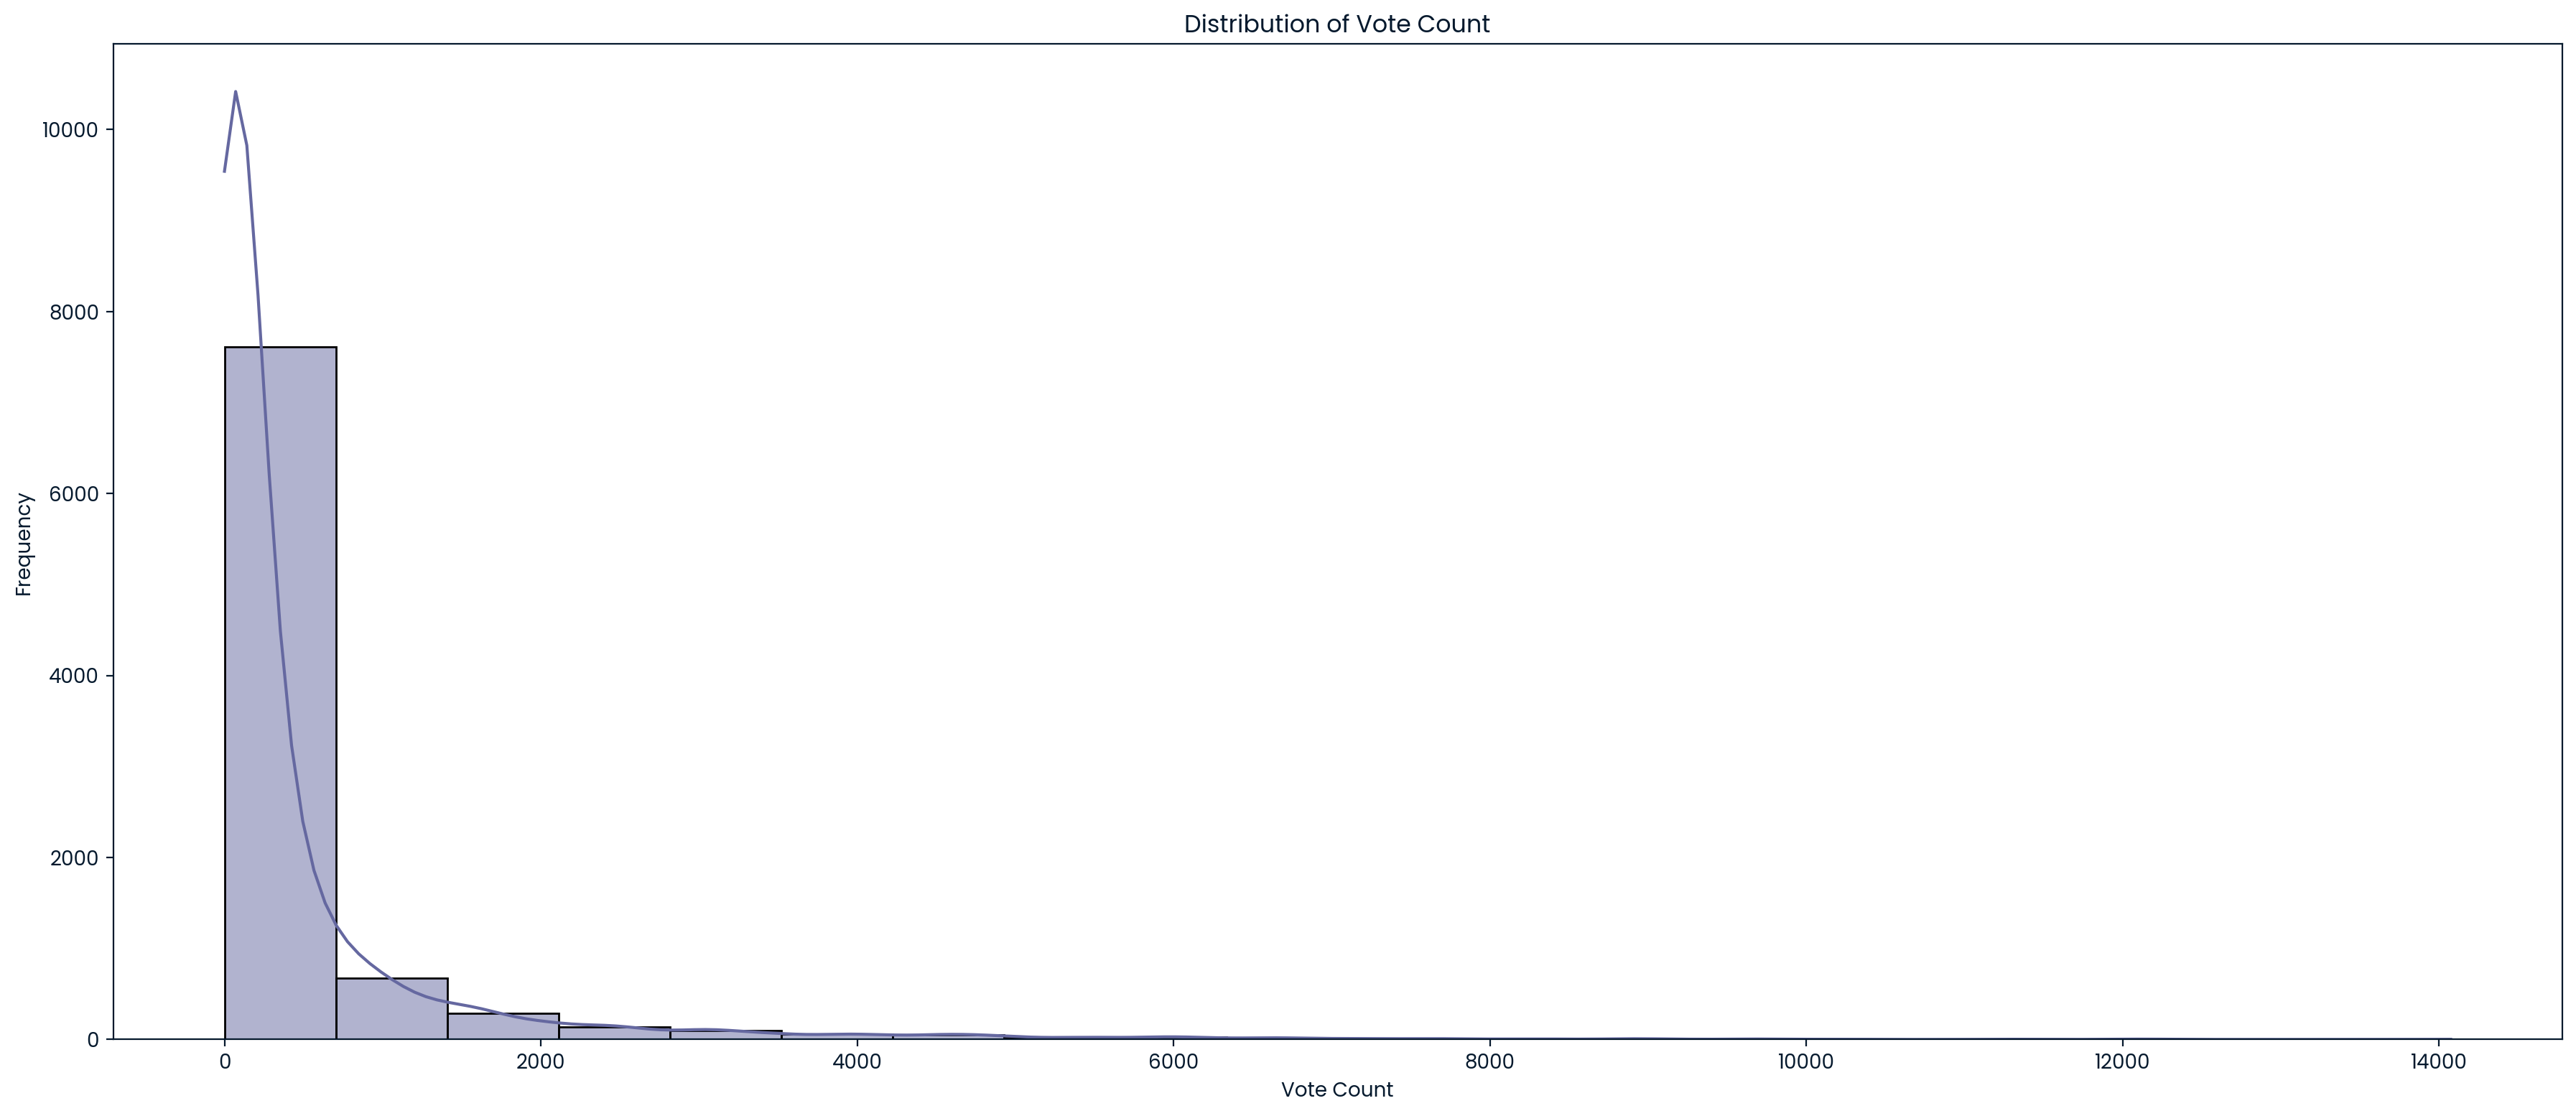

In [5]:
# Visualise the vote_count column
plt.figure(figsize=(22, 9))
sns.histplot(movies_metadata['vote_count'], bins=20, kde=True)
plt.title('Distribution of Vote Count')
plt.xlabel('Vote Count')
plt.ylabel('Frequency')
plt.show()

### Distribution of User Ratings

This histogram represents the ratings users gave to movies on a scale from 0 to 5. It reveals that users tend to give higher ratings, with the majority clustering between 6 and 9. Understanding this trend helps in interpreting rating averages and building collaborative filtering models that account for user bias.


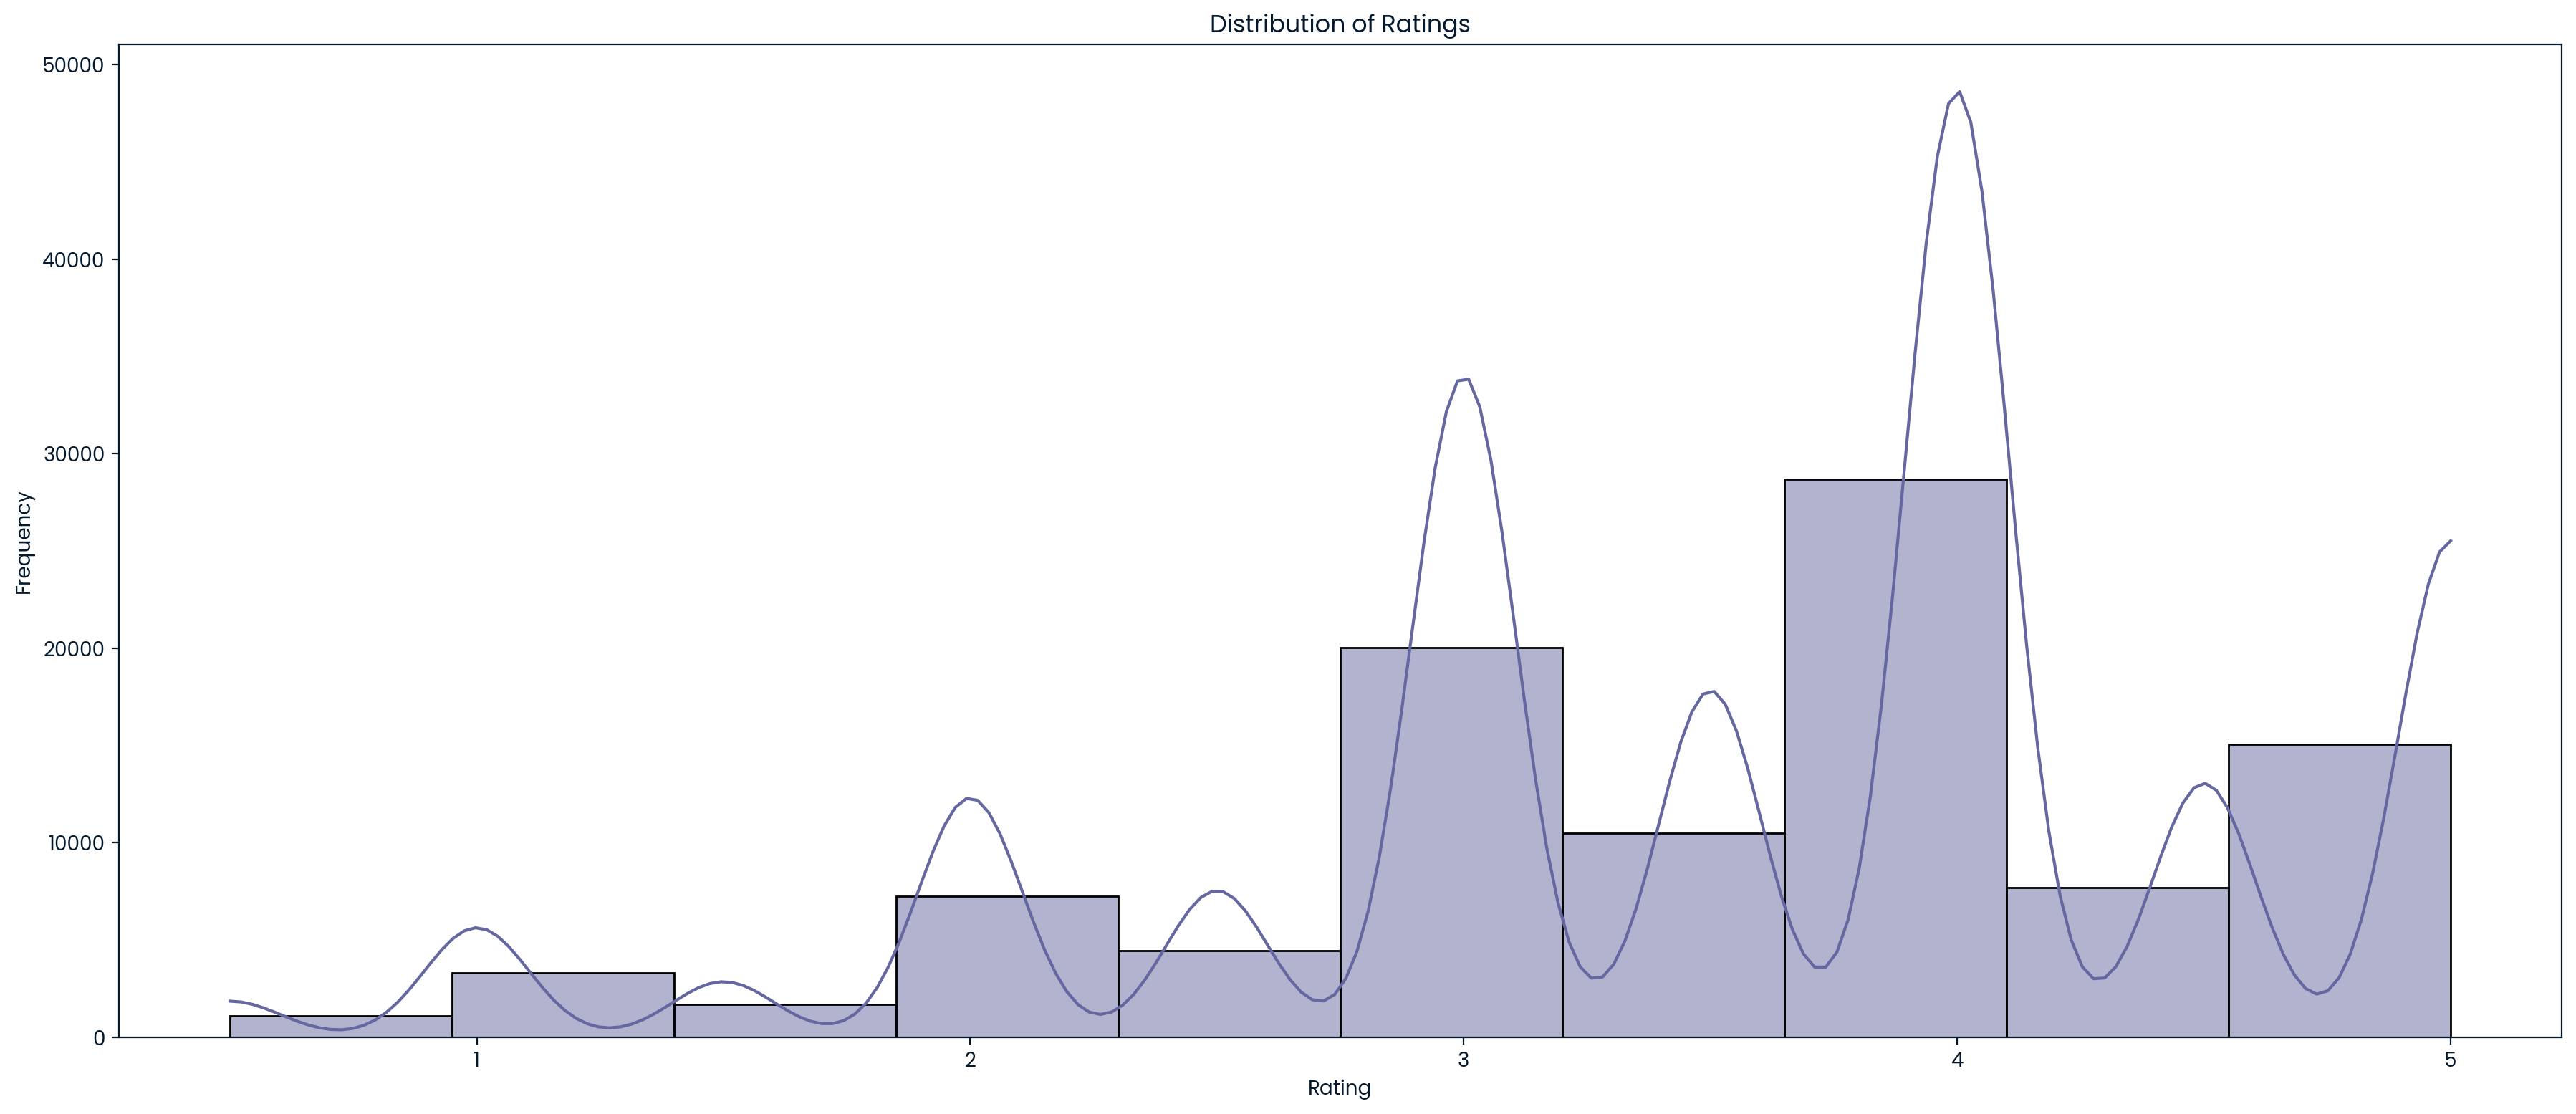

In [6]:
# Visualise the distribution of the rating column
plt.figure(figsize=(22, 9))
sns.histplot(ratings['rating'], bins=10, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

## Task 2: Simple recommender based on popularity or highest rating

In short, a recommender is any system that generates suggestions for an end user. We will start with creating the simplest recommender, one that ranks all movies according to the highest average score, or the highest number of votes. 

This kind of recommender generates the same output for anyone using it. 

### Prompt

Based on movies_metadata, generate a simple recommender that generates recommended movies by either the vote_average or the vote_count. The recommender should be configurable in how many movies it recommends and based on which criterion. 

### 📌 Simple Recommender Function Description

This function generates a simple movie recommender based on a specified criterion.

#### **Parameters:**
- `movies_metadata` (*DataFrame*): The DataFrame containing metadata about movies.
- `criterion` (*str*): The criterion used to rank movies. Acceptable values are `'vote_average'` or `'vote_count'`.
- `top_n` (*int*): The number of top movies to return in the recommendation list.

#### **Returns:**
- *DataFrame*: A DataFrame containing the top `n` recommended movies based on the selected criterion.


In [7]:
def simple_recommender(movies_metadata, criterion='vote_average', top_n=10):
    if criterion not in ['vote_average', 'vote_count']:
        raise ValueError("Criterion must be either 'vote_average' or 'vote_count'")
    
    # Sort the movies by the specified criterion in descending order
    recommended_movies = movies_metadata.sort_values(by=criterion, ascending=False)
    
    # Select the top_n movies
    recommended_movies = recommended_movies.head(top_n)
    
    return recommended_movies

In [8]:
# Example usage:
recommended_movies = simple_recommender(movies_metadata, criterion='vote_count', top_n=10)
recommended_movies

,movie_id,title,overview,vote_average,vote_count
67,1375666.0,Inception,"Cobb, a skilled thief who commits corporate es...",8.1,14075.0
5577,468569.0,The Dark Knight,Batman raises the stakes in his war on crime. ...,8.3,12269.0
5761,499549.0,Avatar,"In the 22nd century, a paraplegic Marine is di...",7.2,12114.0
8033,848228.0,The Avengers,When an unexpected enemy emerges and threatens...,7.4,12000.0
6935,1431045.0,Deadpool,Deadpool tells the origin story of former Spec...,7.4,11444.0
278,816692.0,Interstellar,Interstellar chronicles the adventures of a gr...,8.1,11187.0
6711,1853728.0,Django Unchained,"With the help of a German bounty hunter, a fre...",7.8,10297.0
1360,2015381.0,Guardians of the Galaxy,"Light years from Earth, 26 years after being a...",7.9,10014.0
7828,137523.0,Fight Club,A ticking-time-bomb insomniac and a slippery s...,8.3,9678.0
4484,1392170.0,The Hunger Games,Every year in the ruins of what was once North...,6.9,9634.0


## Task 3: Generate recommendations based on user ratings

We already created a very simple first recommender, but we haven't touched our user data yet! How can this help us? When you watched a movie you liked, you might want to learn which other movies other users liked that also watched that movie. This is where the user data comes in. We can use the ratings to infer which movies are similar to a movie you have already watched! 

### Prompt
Create a recommender that uses the ratings data and generates movie recommendations when you put in a specific movie title.

In [9]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
def content_based_recommender(movie_title, movies_metadata, ratings, top_n=10):
    # Merge movies_metadata with ratings on movie_id
    movie_ratings = pd.merge(movies_metadata, ratings, on='movie_id')
    
    # Create a pivot table with users as rows, movies as columns, and ratings as values
    user_movie_matrix = movie_ratings.pivot_table(index='user_id', columns='title', values='rating')
    
    # Fill NaN values with 0 (assuming unrated movies have a rating of 0)
    user_movie_matrix = user_movie_matrix.fillna(0)
    
    # Check if the movie_title exists in the user_movie_matrix
    if movie_title not in user_movie_matrix.columns:
        raise ValueError(f"Movie title '{movie_title}' not found in the dataset.")
    
    # Compute the cosine similarity between the movie_title and all other movies
    movie_similarities = cosine_similarity(user_movie_matrix.T)
    
    # Create a DataFrame for the similarities
    movie_similarities_df = pd.DataFrame(movie_similarities, index=user_movie_matrix.columns, columns=user_movie_matrix.columns)
    
    # Get the top_n most similar movies to the input movie_title
    similar_movies = movie_similarities_df[movie_title].sort_values(ascending=False).head(top_n + 1).index.tolist()
    
    # Remove the input movie_title from the list
    similar_movies.remove(movie_title)
    
    # Get the metadata for the recommended movies
    recommended_movies = movies_metadata[movies_metadata['title'].isin(similar_movies)]
    
    return recommended_movies

In [11]:
# Example usage:
movie_title = "The Godfather"
recommended_movies = content_based_recommender(movie_title, movies_metadata, ratings, top_n=10)
recommended_movies

,movie_id,title,overview,vote_average,vote_count
20,76759.0,Star Wars,Princess Leia is captured and held hostage by ...,8.1,6778.0
2285,105236.0,Reservoir Dogs,A botched robbery indicates a police informant...,8.1,3821.0
3365,120815.0,Saving Private Ryan,"As U.S. troops storm the beaches of Normandy, ...",7.9,5148.0
3371,99685.0,GoodFellas,"The true story of Henry Hill, a half-Irish, ha...",8.2,3211.0
5575,169547.0,American Beauty,"Lester Burnham, a depressed suburban father in...",7.9,3438.0
5599,71562.0,The Godfather: Part II,In the continuing saga of the Corleone crime f...,8.3,3418.0
6757,73486.0,One Flew Over the Cuckoo's Nest,While serving time for insanity at a state men...,8.3,3001.0
7818,114814.0,The Usual Suspects,"Held in an L.A. interrogation room, Verbal Kin...",8.1,3334.0
7838,82971.0,Raiders of the Lost Ark,When Dr. Indiana Jones – the tweed-suited prof...,7.7,3949.0
7839,78788.0,Apocalypse Now,"At the height of the Vietnam war, Captain Benj...",8.0,2112.0


## Task 4: Generate embeddings based on the movie descriptions

So far, we already created two recommenders! One that didn't take into account your preferences, and one that suggested movies based on similarity to a movie you already saw. Now, we will get creative and let you write a summary of the kind of move you'd like to watch to get recommendations back! 

In order to do this, we will rely on a concept called *embeddings*. In a nutshell, embeddings are numerical representations of a piece of text and they are critical to the success of the most recent generation of AI models, like ChatGPT. We will take the description of our movies and convert these to their embedded form. 

### Prompt
Take the overview field from movies_metadata. These are short descriptions from movies. Use a simple local llm model to generate embeddings for each movie 

The most important library we are using in this task is called **sentence_transformers**. Very shortly put, a sentence transformer is a type of LLM that allows us to transform a sentence into a numerical representation.

In [17]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from tqdm import tqdm

In [18]:
# Load a pre-trained model from Sentence Transformers
model = SentenceTransformer('all-MiniLM-L6-v2')

In [19]:
# Ensure the 'overview' column is filled with strings
movies_metadata['overview'] = movies_metadata['overview'].fillna('').astype(str)

In [20]:
# Generate embeddings for each movie overview
tqdm.pandas(desc="Generating embeddings")
movies_metadata['embedding'] = movies_metadata['overview'].progress_apply(lambda x: model.encode(x).tolist())

Generating embeddings: 100%|██████████| 9010/9010 [16:35<00:00,  9.05it/s]


## Task 5: Use embedding simillarity to generate recommendations

Now we are ready to create a new recommender function where we submit a description of a movie we want to watch and get recommendations back. 

### Prompt
Create a recommender that takes the embeddings in movies_metadata and a user-generated input that describes a movie they'd like to watch. Calculate the similarity between the embedding of that description with all movie embeddings and return the top n most similar movies.

The output of the prompt reuses what we created in the previous task, and wraps it into a function. Let's have a look at what's happening. 

The `recommend_movies` function takes a particular `user_input`, the metadata data set, a model, and a `top_n` argument. The user input can be anything, but preferably a short sentence describing what kind of movie you'd like to see. The metadata is being used to retrieve the embeddings we generated, and the model will be used to generate the embedding of the input text. 

The function goes through the following steps: 
- Create an embedding of the input text. 
- Calculate the similarity between the input text embedding and the embedding of all movies. 
- Sort based on those similarity values and select top_n. 
- Return a subset of the data set with the movie title and description. 

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_movies(user_input, movies_metadata, model, top_n=5):
    # Generate embedding for the user input
    user_embedding = model.encode(user_input).tolist()
    
    # Calculate cosine similarity between user input embedding and all movie embeddings
    movies_metadata['similarity'] = movies_metadata['embedding'].apply(lambda x: cosine_similarity([user_embedding], [x])[0][0])
    
    # Sort movies by similarity in descending order and get the top n movies
    top_movies = movies_metadata.sort_values(by='similarity', ascending=False).head(top_n)
    
    return top_movies[['title', 'overview', 'similarity']]

## Task 6: Put it all together into a single function

In this final task, we will be putting all previous recommenders together into one single function that will allow you to generate an awesome movie night! 

### Prompt
Combine the three different recommenders we used before, the first one being a recommender based on vote_average or vote_count, the second one based on the ratings data where the most similar movies would be returned for a given movie title, and the third one being a recommender based on the movie embeddings that are most similar to a user-generated prompt. One of the three options should be returned.


In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def recommend_movies(method='vote_average', movie_title=None, user_prompt=None, top_n=10):
    if method == 'vote_average':
        # Recommender based on vote_average or vote_count
        recommended = movies_metadata.sort_values(by=['vote_average', 'vote_count'], ascending=False).head(top_n)
        return recommended[['title', 'overview', 'vote_average', 'vote_count']]
    
    elif method == 'similar_movies' and movie_title:
        # Recommender based on the ratings data where the most similar movies would be returned for a given movie title
        movie_id = movies_metadata[movies_metadata['title'] == movie_title]['movie_id'].values[0]
        user_ratings = ratings[ratings['movie_id'] == movie_id]
        similar_users = ratings[ratings['user_id'].isin(user_ratings['user_id'])]
        similar_movies = similar_users.groupby('movie_id').agg({'rating': 'mean'}).reset_index()
        similar_movies = similar_movies.merge(movies_metadata, on='movie_id')
        similar_movies = similar_movies.sort_values(by='rating', ascending=False).head(top_n)
        return similar_movies[['title', 'overview', 'rating']]
    
    elif method == 'embedding' and user_prompt:
        # Recommender based on the movie embeddings that are most similar to a user-generated prompt
        user_embedding = np.mean([movies_metadata[movies_metadata['title'] == title]['embedding'].values[0] for title in user_prompt], axis=0)
        movies_metadata['similarity'] = movies_metadata['embedding'].apply(lambda x: cosine_similarity([user_embedding], [x])[0][0])
        recommended = movies_metadata.sort_values(by='similarity', ascending=False).head(top_n)
        return recommended[['title', 'overview', 'similarity']]
    
    else:
        raise ValueError("Invalid method or missing parameters")

# Example usage:
recommend_movies(method='vote_average', top_n=5)
# recommend_movies(method='similar_movies', movie_title='The Matrix', top_n=5)
# recommend_movies(method='embedding', user_prompt=['The Matrix', 'Inception'], top_n=5)

,title,overview,vote_average,vote_count
430,Survive and Advance,"In 1983, the NC State Wolfpack, coached by Jim...",10.0,2.0
7463,Common Threads: Stories from the Quilt,"In the late 1970s, a mysterious new disease be...",10.0,2.0
873,"Dancer, Texas Pop. 81","Four guys, best friends, have grown up togethe...",10.0,1.0
2882,"The Haunted World of Edward D. Wood, Jr.",The strange life and the wonderfully awful fil...,10.0,1.0
6603,Chilly Scenes of Winter,A man falls for a separated woman but can't co...,10.0,1.0
